In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

import copy

import cv2

In [2]:
dfAll = pd.read_pickle("DataStudyEvaluation/AllData.pkl")
df = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
56454,12,1553865148939,1,510,17,2,0,True,False,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
56455,12,1553865148981,1,510,17,2,0,True,False,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
56456,12,1553865149021,1,510,17,2,0,True,False,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
56457,12,1553865149060,1,510,17,2,0,True,False,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
56458,12,1553865149099,1,510,17,2,0,True,False,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."


In [3]:
df.userID.unique()

array([12,  5,  1, 10,  6,  3,  7,  8,  9, 11])

In [4]:
%%time
def is_max(df):
    df_temp = df.copy(deep=True)
    max_version = df_temp.RepetitionID.max()
    df_temp["IsMax"] = np.where(df_temp.RepetitionID == max_version, True, False)
    df_temp["MaxRepetition"] = [max_version] * len(df_temp)
    return df_temp

df_grp = df.groupby([df.userID, df.TaskID, df.VersionID])
pool = Pool(cpu_count() - 1)
result_lst = pool.map(is_max, [grp for name, grp in df_grp])
df = pd.concat(result_lst)
pool.close()

CPU times: user 12.2 s, sys: 2.34 s, total: 14.6 s
Wall time: 14.2 s


In [5]:
df.Image = df.Image.apply(lambda x: x.reshape(27, 15))
df.Image = df.Image.apply(lambda x: x.clip(min=0, max=255))
df.Image = df.Image.apply(lambda x: x.astype(np.uint8))
df["ImageSum"] = df.Image.apply(lambda x: np.sum(x))

In [6]:
df.to_pickle("DataStudyEvaluation/dfFiltered.pkl")

In [7]:
print("recorded actual: %s, used data: %s" % (len(dfAll), len(df)))

recorded actual: 608084, used data: 413500


In [8]:
df = pd.read_pickle("DataStudyEvaluation/dfFiltered.pkl")

In [9]:
df.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,IsMax,MaxRepetition,ImageSum
178160,1,1553521741802,16,510,0,2,0,True,False,"[[0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 2, 1, 1, 0, 1]...",False,1,286
178161,1,1553521741842,16,510,0,2,0,True,False,"[[0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 2, 1, 1, 0, 1]...",False,1,319
178162,1,1553521741882,16,510,0,2,0,True,False,"[[0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 2, 1, 1, 0, 1]...",False,1,72
178163,1,1553521741922,16,510,0,2,0,True,False,"[[0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 2, 1, 1, 0, 1]...",False,1,288
178164,1,1553521741990,16,510,0,2,0,True,False,"[[0, 1, 1, 1, 0, 1, 0, 4, 1, 0, 2, 1, 1, 0, 1]...",False,1,308


In [10]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df['InputMethod'] = df.apply(f, axis=1)

def f(row):
    if row['TaskID'] < 17:
        val = "Knuckle"
    elif row['TaskID'] >= 17:
        val = "Finger"
    return val
df['Input'] = df.apply(f, axis=1)

In [11]:
#Svens new Blob detection
def detect_blobs(image, task):
    #image = e.Image
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = np.copy(image)
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    contours.sort(key=lambda a: cv2.contourArea(a))
    if len(contours) > 0:
        # if two finger or knuckle
        cont_count = 2 if task in [1, 6, 7, 18, 23, 24] and len(contours) > 1 else 1
        for i in range(1, cont_count + 1):
            max_contour = contours[-1 * i]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            #croped_im = np.zeros((27,15))
            blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
            #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            #return (1, [croped_im])
            lstBlob.append(blob)
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            count = count + 1
        return (count, lstBlob, lstMin, lstMax)
    else:
        return (0, [np.zeros((29, 19))], 0, 0)

In [12]:
%%time
pool = Pool(os.cpu_count()-1)
temp_blobs = pool.starmap(detect_blobs, zip(df.Image, df.TaskID))
pool.close()

CPU times: user 5.65 s, sys: 4.52 s, total: 10.2 s
Wall time: 9.76 s


In [13]:
df["BlobCount"] = [a[0] for a in temp_blobs]
df["BlobImages"] = [a[1] for a in temp_blobs]
df["BlobW"] = [a[2] for a in temp_blobs]
df["BlobH"] = [a[3] for a in temp_blobs]

In [14]:
df.BlobCount.value_counts()

0    334475
1     73449
2      5576
Name: BlobCount, dtype: int64

In [15]:
dfX = df[(df.BlobCount == 1)].copy(deep=True)
dfX.BlobImages = dfX.BlobImages.apply(lambda x : x[0])
dfX.BlobW = dfX.BlobW.apply(lambda x : x[0])
dfX.BlobH = dfX.BlobH.apply(lambda x : x[0])

dfY = df[(df.BlobCount == 2)].copy(deep=True)
dfY.BlobImages = dfY.BlobImages.apply(lambda x : x[0])
dfY.BlobW = dfY.BlobW.apply(lambda x : x[0])
dfY.BlobH = dfY.BlobH.apply(lambda x : x[0])

dfZ = df[(df.BlobCount == 2)].copy(deep=True)
dfZ.BlobImages = dfZ.BlobImages.apply(lambda x : x[1])
dfZ.BlobW = dfZ.BlobW.apply(lambda x : x[1])
dfZ.BlobH = dfZ.BlobH.apply(lambda x : x[1])

df = dfX.append([dfY, dfZ])

In [16]:
print("Sample Size not Argumented:", len(df))

Sample Size not Argumented: 84601


In [17]:
df["BlobArea"] = df["BlobW"] * df["BlobH"]

In [18]:
df.BlobArea.describe().round(1)

count    84601.0
mean        16.5
std          5.9
min         12.0
25%         12.0
50%         16.0
75%         16.0
max         72.0
Name: BlobArea, dtype: float64

In [19]:
df.groupby("Input").BlobArea.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
Input,,,,,,,,
Finger,59879.0,17.3,5.8,12.0,12.0,16.0,20.0,56.0
Knuckle,24722.0,14.8,5.7,12.0,12.0,12.0,16.0,72.0


In [20]:
df["BlobSum"] = df.BlobImages.apply(lambda x: np.sum(x))

In [21]:
df.BlobSum.describe()

count    84601.000000
mean      1238.209170
std        485.150602
min        467.000000
25%        930.000000
50%       1094.000000
75%       1383.000000
max       4275.000000
Name: BlobSum, dtype: float64

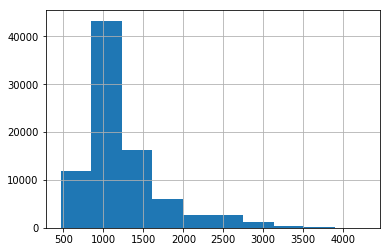

In [22]:
df.BlobSum.hist()

In [23]:
#Small / Blobs where the pixels are only a "little" hit
dfX = df[df.BlobSum <= 255]
len(dfX)

0

In [24]:
print("Sample Size argumented:", len(df))

Sample Size argumented: 84601


In [25]:
def pasteToEmpty (blob):
    croped_im = np.zeros((27,15))
    croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
    return croped_im

In [26]:
df["Blobs"] = df.BlobImages.apply(lambda x: pasteToEmpty(x))

In [27]:
df.to_pickle("DataStudyEvaluation/df_statistics.pkl")

In [28]:
df[["userID", "TaskID", "Blobs", "InputMethod"]].to_pickle("DataStudyEvaluation/df_blobs_area.pkl")

# display blobs

userID                                                           1
Timestamp                                            1553522289862
Current_Task                                                   155
Task_amount                                                    510
TaskID                                                           0
VersionID                                                       11
RepetitionID                                                     0
Actual_Data                                                   True
Is_Pause                                                     False
Image            [[1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 0, 3, 0, 0]...
IsMax                                                         True
MaxRepetition                                                    0
ImageSum                                                       933
InputMethod                                                      0
Input                                                      Knu

<Figure size 432x288 with 0 Axes>

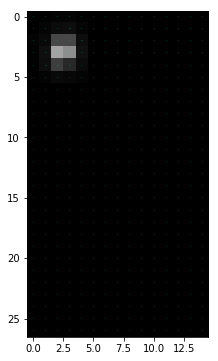

In [29]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 100
data = df.Blobs.iloc[data_point]
print(df.iloc[data_point])
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
plt.show()